In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras import layers , models


In [ ]:
Model_name = "Stock_Predictor_v1"
epochs = 50
batch_size = 32
max_days = 60
learning_rate = 1e-4
data_path = r"Stocks/clean_data/combined_stocks_data.csv"


In [52]:
from sklearn.preprocessing import MinMaxScaler
import joblib
import pandas as pd

features = ["Open", "High", "Low", "Close", "Volume", "CompanyID", "weekday", "year", "month", "day"]
df = pd.read_csv(data_path, usecols=features)
scaler = MinMaxScaler()
scaler.fit(df[features].values)
joblib.dump(scaler, "Models/scaler.pkl")


['Models/scaler.pkl']

In [ ]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length][3]  
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X, y = create_sequences(data, seq_length=max_days)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

In [ ]:
stock = models.Sequential()
stock.add(layers.LSTM(128, return_sequences=True, input_shape=(max_days, len(features))))
stock.add(layers.Dropout(0.2))
stock.add(layers.LSTM(64, return_sequences=False))
stock.add(layers.Dropout(0.2))
stock.add(layers.Dense(32, activation='relu'))
stock.add(layers.Dense(1))
stock.compile(optimizer='adam', loss='mean_squared_error')
stock.summary()


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint = ModelCheckpoint(f"{Model_name}.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks = [checkpoint, early_stop, reduce_lr, tensorboard_callback]

In [ ]:
history = stock.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=callbacks)

301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
MSE: 0.048724423318065944
RMSE: 0.22073609428017418


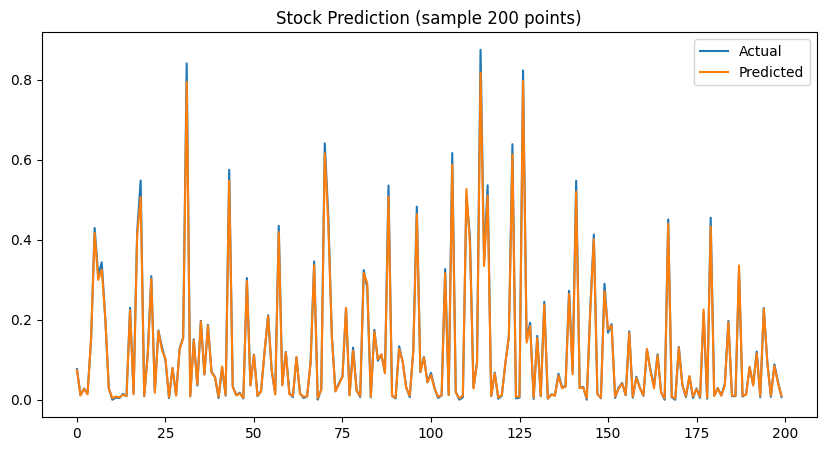

In [51]:
from matplotlib import pyplot as plt
import numpy as np
predicted = stock.predict(X_test)
mse = np.mean(np.square(y_test - predicted))
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)
plt.figure(figsize=(10,5))
plt.plot(y_test[:200], label='Actual')
plt.plot(predicted[:200], label='Predicted')
plt.legend()
plt.title("Stock Prediction (sample 200 points)")
plt.show()


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
scalar = joblib.load("Models/scaler.pkl")
y_pred = stock.predict(X_test)

y_pred_rescaled = scalar.inverse_transform(
    np.hstack((y_pred, np.zeros((y_pred.shape[0], len(features) - 1))))
)[:, 0]

y_test_rescaled = scalar.inverse_transform(
    np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))))
)[:, 0]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"📊 Model Evaluation:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.6f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

accuracy = 100 - np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
print(f"Approx Accuracy: {accuracy:.2f}%")


301/301 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
📊 Model Evaluation:
MAE  : 7.4078
MSE  : 427.799421
RMSE : 20.6833
R²   : 0.9924
Approx Accuracy: 57.27%


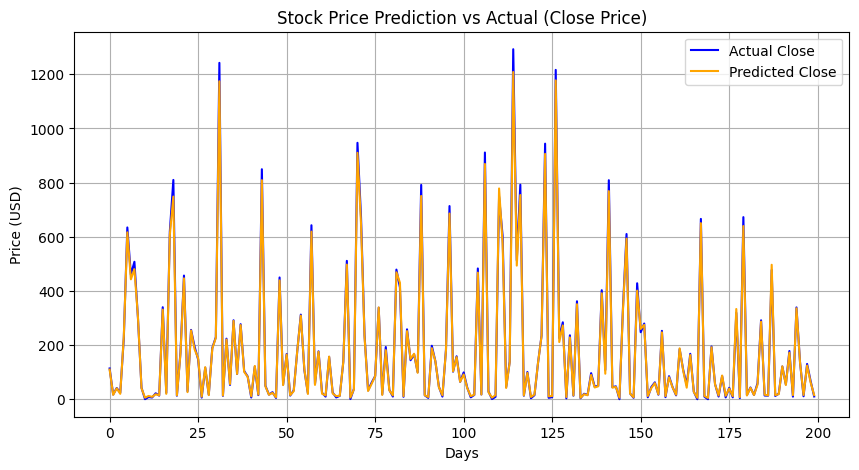

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dummy = np.zeros((len(y_test), len(features))) 
dummy_pred = np.zeros((len(y_pred), len(features)))

close_index = features.index("Close")

dummy[:, close_index] = y_test.flatten()
dummy_pred[:, close_index] = y_pred.flatten()

y_test_actual = scalar.inverse_transform(dummy)[:, close_index]
y_pred_actual = scalar.inverse_transform(dummy_pred)[:, close_index]

plt.figure(figsize=(10, 5))
plt.plot(y_test_actual[:200], label="Actual Close", color='blue')
plt.plot(y_pred_actual[:200], label="Predicted Close", color='orange')
plt.title("Stock Price Prediction vs Actual (Close Price)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()
